In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

from model_training_helpers import ModelTrainingArtifact

In [2]:
# First set of experiments
num_epochs_list = [20, 30, 40]
hidden_layer_dims_list = [[1024, 256], [1024, 512], [1024, 128]]
weight_init_method_list = ['xavier_uniform', 'random_normal', 'kaiming_uniform']
batch_norm_list = [True, False]
activation_function_list = [F.relu]
dropout_rate_layers_list = [.5, .3, .2, .1]
optimizer_list = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]
learning_rates = [0.01, 0.001, 0.0001]
momentums = [0.9, 0.95, 0.99]

In [3]:
# Second set of experiments
num_epochs_list = [40]
hidden_layer_dims_list = [[1024, 256]]
weight_init_method_list = ['xavier_uniform', 'kaiming_uniform']
batch_norm_list = [True]
activation_function_list = [F.relu]
dropout_rate_layers_list = [.5, .3, .2, .1]
optimizer_list = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]
learning_rates = [0.1, 0.01, 0.001]
momentums = [0.9, 0.95, 0.99]

In [5]:
for i in range(3):
    for j in range(1,3):
        print(i*j)
        break
    break
del i, j

0


In [6]:
def run_all_experiments():
    for num_epochs in num_epochs_list:
        for hidden_layer_dims in hidden_layer_dims_list:
            for weight_init_method in weight_init_method_list:
                for batch_norm in batch_norm_list:
                    for activation_function in activation_function_list:
                        for lr in learning_rates:
                            for optimizer in optimizer_list:
                                if optimizer == torch.optim.SGD:
                                    optimizer_hyperparams = {'lr': lr, 'momentum': np.random.choice(momentums)}
                                elif optimizer == torch.optim.Adam:
                                    optimizer_hyperparams = {'lr': lr, 'betas': tuple(np.random.choice(momentums, 2))}
                                elif optimizer == torch.optim.RMSprop:
                                    optimizer_hyperparams = {'lr': lr, 'alpha': np.random.choice(momentums)}
                                model = ModelTrainingArtifact(
                                    optimizer=optimizer,
                                    objective=nn.CrossEntropyLoss(),
                                    num_epochs=num_epochs,
                                    hidden_layer_dims=hidden_layer_dims,
                                    weight_init_method=weight_init_method,
                                    batch_norm=batch_norm,
                                    activation_function=activation_function,
                                    dropout_rate_layers=np.random.choice(dropout_rate_layers_list, len(hidden_layer_dims)).tolist(),
                                    optimizer_hyperparams=optimizer_hyperparams,
                                )
                                model.train()
                                model.test(record_experiment=True)
                                break
                            break
                        break
                    break
                break
            break
        break
    

In [7]:
run_all_experiments()

epoch:39 train loss:0.1175 train accuracy:0.9625: 100%|██████████| 4240/4240 [02:18<00:00, 30.64it/s]


Mean Accuracy Across Each Batch of the test set: 0.8992 ± 0.02426


In [2]:
model = ModelTrainingArtifact(
    optimizer=torch.optim.SGD,
    objective=nn.CrossEntropyLoss(),
    num_epochs=2,
    hidden_layer_dims=[1024, 256],
    weight_init_method='random_normal',
    batch_norm=True,
    activation_function=F.relu,
    dropout_rate_layers=[.5, .5],  # No dropout
    optimizer_hyperparams={'lr': 0.01, 'momentum': 0.9},
)
model.train()
model.test(record_experiment=True)

epoch:1 train loss:1.7109 train accuracy:0.5833: 100%|██████████| 212/212 [00:07<00:00, 28.22it/s]


Mean Accuracy Across Each Batch of the test set: 0.7199 ± 0.03928


## Appendix: Plot and Visualize some of the training images.

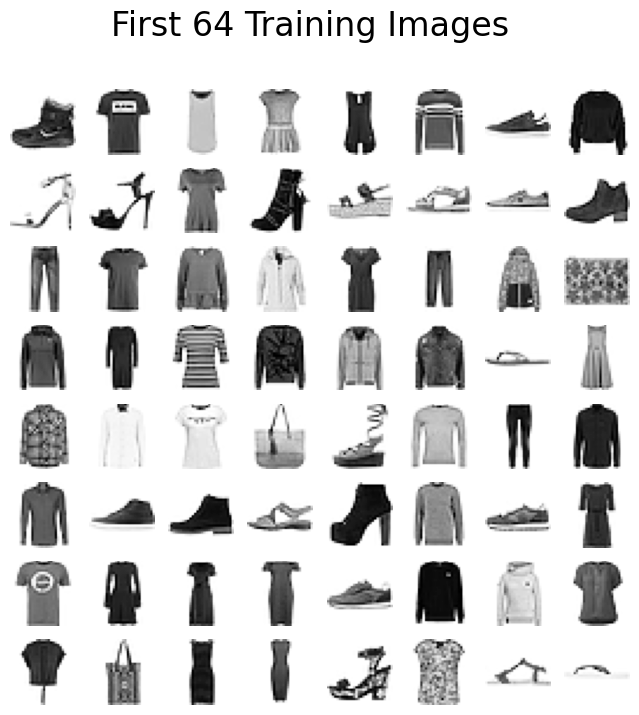

In [17]:
# Sample code to visulaize the first sample in first 16 batches 

# batch_num = 0
# for train_features, train_labels in train_batches:
    
#     if batch_num == 16:
#         break    # break here
    
#     batch_num = batch_num +1
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")
    
#     img = train_features[0].squeeze()
#     label = train_labels[0]
#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(f"Label: {label}")

# Sample code to plot N^2 images from the dataset
def plot_images(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )

## OH Notes:

* Play around with number of hidden layers and number of nodes in each layer
* Don't use too many layers (maybe only 2 or 3)
* explain forward and backward pass and fully connected layer
* What is a hidden layer?
* One concise paragraph about optimization methods (a single key equation)
* 